In [2]:
import pandas
x = pandas.read_csv('test.csv',index_col='id')
x.index

Int64Index([     4,      6,      9,     12,     15,     17,     21,     28,
                32,     43,
            ...
            587583, 587587, 587596, 587610, 587613, 587617, 587621, 587627,
            587629, 587634],
           dtype='int64', name='id', length=125546)

In [ ]:
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)


#maes =[]
def meanAbsErrorByComponents(components, hidden_layer, X_train, X_test, y_train, y_test):
    pca = PCA(n_components=components)
    
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    #X_train = StandardScaler().fit_transform(X_train)
    X_test = pca.transform(X_test)
    #X_test = StandardScaler().fit_transform(X_test)
    reg =  MLPRegressor(hidden_layer_sizes=hidden_layer)
    reg.fit(X_train,y_train)
    y_pred = reg.predict(X_test)
    #y_pred = y_pred**2
    mae = sum(abs(y_pred-(y_test)))/y_pred.shape[0]
    #mae = sum(abs(y_pred-(y_test)))/y_pred.shape[0]
    return mae
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
maes = numpy.zeros((5,8))
for j, components in enumerate(range(110,150,5)):
    for i, nodes in enumerate(range(150,250,20)):
        t = time.time()
        m =  meanAbsErrorByComponents(components,(nodes,), X_train, X_test, y_train, y_test)
        elapsed = time.time()-t
        maes[i,j] = m
        #maes.append((i,j,m)) #components, 
        print (i,j,m,elapsed)

matplotlib.pyplot.plot(maes)
matplotlib.pyplot.show()

In [ ]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.decomposition import PCA
import time, numpy
# Fit estimators
ESTIMATORS = {
   # "Extra trees": ExtraTreesRegressor(n_estimators=10,  max_features=32, 
   #                                    criterion='mae'),
   # "K-nn": KNeighborsRegressor(),
    "Linear regression": LinearRegression(),
   # "Ridge": RidgeCV(),
    "MLP":  MLPRegressor(hidden_layer_sizes=(150,))
}

y_test_predict = {}

for name, estimator in ESTIMATORS.items():
    t_0 = time.time()
    print(name)
    if name in ('K-nn',"Linear regression"):
        if name == 'MLP':
            components = 115
        elif name == 'K-nn':
            components = 40
        else:
            components = 115
        pca = PCA(n_components=components)
    
        pca.fit(X_train)
        X_train_ = pca.transform(X_train)
        X_test_ = pca.transform(X_test)
    else:
        X_train_ = X_train
        X_test_ = X_test
    estimator.fit(X_train_, y_train)
    
    t_1 = time.time()
    print(f'Time elapsed for fitting of model {t_1 - t_0:.3f} sec')
    y_test_predict[name] = estimator.predict(X_test_)
    print(f'Time elapsed for prediction {time.time() - t_1:.3f} sec')
    error = numpy.sum(numpy.abs(y_test_predict[name] - y_test)) / len(y_test)
    print(f'error: {error:.3f}')


In [ ]:
y_test_predict = {}
for i in range(1,61):
    pca = PCA(n_components=i)
    
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    #X_train = StandardScaler().fit_transform(X_train)
    X_test = pca.transform(X_test)
    t_0 = time.time()
    print(i)
    estimator.fit(X_train, y_train)
    
    t_1 = time.time()
    print(f'Time elapsed for fitting of model {t_1 - t_0:.3f} sec')
    y_test_predict[i] = estimator.predict(X_test)
    print(f'Time elapsed for prediction {time.time() - t_1:.3f} sec')
    
for components, y_hat in y_test_predict.items():
    error = numpy.sum(numpy.abs(y_hat - y_test)) / len(y_test)
    print(f'{components}, error: {error:.3f}')

In [3]:
import numpy
for name, y_hat in y_test_predict.items():
    error = numpy.sum(numpy.abs(y_hat - y_test)) / len(y_test)
    print(f'{name}, error: {error:.3f}')

Linear regression, error: 1341.522


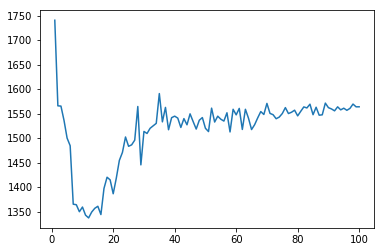

In [14]:
import matplotlib.pyplot

matplotlib.pyplot.plot(range(1,101),maes)
matplotlib.pyplot.show()

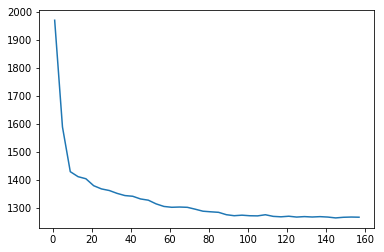

In [23]:
#This shows that adding PCA components beyond >115 does not have much effect.
matplotlib.pyplot.plot(range(1,161,4),maes)
matplotlib.pyplot.show()

In [25]:
import tensorflow, time
import os
import numpy
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization
#from keras.callbacks import ModelCheckpoint
from keras.layers import Dropout
import keras.callbacks
from keras import optimizers
from keras import regularizers
from keras.constraints import maxnorm
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
from sklearn.model_selection import train_test_split

def ContColumns(X):
    contColumns = [c for c in X.columns if c.startswith('cont')]
    return X[contColumns]

def CatColumns(X):
    catColumns = [c for c in X.columns if c.startswith('cat')]
    return X[catColumns]

def PCACont(X, components =6):
    pcaIn = ContColumns(X)
    ret = PCA(n_components = components).fit_transform(pcaIn)
    #print(X.columns)
    r = X.drop(columns=pcaIn.columns)
    for i in range(components):
        r['pca%d'%(i+1)]=ret[:,i]
    #print (r.columns)
    return r

def SelectCategorical(X,thresh=0.05):
    kbIn = CatColumns(X)
    kb = VarianceThreshold(thresh)
    ret = kb.fit_transform(kbIn)
    r = X.drop(columns=kbIn.columns)
    for i in range(ret.shape[1]):
        r["cat%d"%(i+1)] = ret[:,i]
    return r


class PrepareData:
    def __init__(self, pcaCount, catK):
        self.catK = catK
        self.pcaCount = pcaCount
        
    def fit(self, X, y):
        pcaIn = ContColumns(X)
        self.pca = PCA(n_components = self.pcaCount)
        self.pca.fit(pcaIn)
        self.kbest = SelectKBest(score_func = f_regression, k = self.catK)
        kbIn = CatColumns(X)
        yIn = numpy.log1p(y)
        self.kbest.fit(kbIn, yIn)
    def transform(self, X):
        pcaIn = ContColumns(X)
        kbIn = CatColumns(X)
        r1 = self.kbest.transform(kbIn)
        r2 = self.pca.transform(pcaIn)
        return numpy.c_[r1,r2]
    
class CustomMLPRegressor:
    """provide a similar interface to the sklearn regressors"""
    def __init__(self, nodes, earlyStopping, dropout):
      
        if type(nodes) is int:
            nodes = (nodes,)
        self.nodes = nodes
        self.dropout = dropout
        self.earlyStopping = earlyStopping
        
    def fit(self, X, y):
        inputDim = X_train.shape[1]
        model = Sequential()
        for i, nodeCount in enumerate(self.nodes):
            if i == 0:
                if len(self.nodes) == 1:
                    self.model.add(Dense(nodeCount, input_dim = inputDim, activation='relu'))
                else:
                    self.model.add(Dense(nodeCount, input_dim = inputDim, activation='relu', kernel_constraint = maxnorm(3)))
                    if dropout:
                        model.add(Dropout(dropout))
            else:
                if len(self.nodes) > i+1:
                    self.model.add(Dense(nodeCount,  activation='relu', kernel_constraint = maxnorm(3)))
                    if dropout:
                        model.add(Dropout(dropout))
                else:
                    self.model.add(Dense(nodeCount,  activation='relu'))
        model.add(Dense(1))
        opt = optimizers.Nadam()
        model.compile(loss='mean_absolute_error', optimizer=opt)
        self.model = model
        
        callback_list = []
        filepath="weights-best.hdf5"
        checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
        callback_list.append(checkpoint)
        if self.earlyStopping:
            callback_list.append(keras.callbacks.EarlyStopping(min_delta=self.earlyStopping, patience=5,verbose=0))
        history=model.fit(X_train, y_train, 
              epochs=epochs, batch_size=1000,
              verbose=0,validation_split=0.2,callbacks=callback_list)
        bestModel = keras.models.load_model('weights-best.hdf5')
        self.model =bestModel
        return self
    def predict(self, X):
        return self.model.predict(X)

    
    
def TestMLP(X_train, X_test, y_train, y_test, nodes, contFeatures, catFeatures,lr, epochs, earlyStopping = 0.1, dropout = 0.2):
    
  
    inputNodes = X_train.shape[1]
    filepath="weights-best.hdf5"
    
    model = Sequential()
    model.add(Dense(nodes, input_dim=X_train.shape[1], activation='relu', kernel_constraint = maxnorm(3)))
    model.add(Dropout(dropout))#model.add(BatchNormalization())
    model.add(Dense(64, activation='relu', kernel_constraint = maxnorm(3)))
    model.add(Dropout(dropout))
    model.add(Dense(16, activation='relu'))
   # model.add(Dropout(dropout))
    model.add(Dense(1))
    opt = optimizers.Nadam()
    model.compile(loss='mean_absolute_error', optimizer=opt)
    t = time.time()
    #print (X_train.shape)
    callback_list = []
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
    callback_list.append(checkpoint)
    if earlyStopping:
        
        callback_list.append(keras.callbacks.EarlyStopping(min_delta=earlyStopping, patience=5,verbose=0))
   
    score = model.evaluate(X_test, y_test, verbose=0)
    #print('Time taken:', time.time()-t)
    bestModel = keras.models.load_model('weights-best.hdf5')
    scoreBest = bestModel.evaluate(X_test, y_test, verbose=0)
    try:
        os.rename('weights-best.hdf5','weights-best-%.2f-%d-%d-%.2f.hdf5'%(scoreBest, inputNodes, nodes, dropout))
    except FileExistsError:
        pass #
    if not contFeatures:
        pd = None
    return scoreBest, bestModel, time.time()-t, pd


In [ ]:
results = numpy.zeros((5,5))
minResults = numpy.zeros((5,5))
minModel = None
minScore = None
X_train, X_test, y_train, y_test = train_test_split(X.astype('float32'), y.astype('float32'), test_size=0.20)
dropout = 0.2
#nodes = 600
for i in range(5):
#    contFeatures = 5+i
    dropout = ((i+2)*0.05)
    for j in range(5):
#        catFeatures = 300+j*20
        nodes = j*50+400
        scores = 0
        for z in range(4):
            score, model,duration, preparer = TestMLP(X_train, X_test, y_train, y_test, nodes,0,0, 0.01, 100,1, dropout = dropout)
            if z== 0:
                minResults[(i,j)] = score
            elif minResults[(i,j)] > score:
                minResults[(i,j)] = score
            if minModel is None:
                minModel = model, preparer
                minScore = score
            elif minScore > score:
                minModel = model, preparer
                minScore = score
            scores += score
            print (score, contFeatures, catFeatures, duration)
        results[(i,j)]=scores/4
        print (contFeatures,catFeatures,scores/4,minResults[(i,j)])

matplotlib.pyplot.imshow(results,cmap='gray')
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()
matplotlib.pyplot.imshow(minResults,cmap='gray')
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()


1168.501731334547 6 340 794.2447257041931


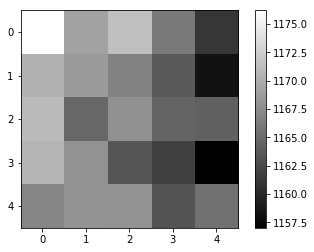

In [10]:
matplotlib.pyplot.imshow(results,cmap='gray')
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

In [7]:

nodes = 240
results = numpy.zeros(20)
contFeatures = 7
catFeatures = 320
for i in range(20):
    earlyStopping = i/20
    score, model,duration = TestMLP(nodes, contFeatures, catFeatures, 0.01, 5000,earlyStopping)
    results[i]=score
    print('Nodes: %d, Cont Features: %d, Cat Features: %d EarlyStopping: %f score:%f, time taken: %f'%(nodes,contFeatures,catFeatures, earlyStopping, score,duration))
matplotlib.plot(results)
matplotlib.show()

C:\Users\emagnusson\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\emagnusson\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\emagnusson\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\emagnusson\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


IndexError: too many indices for array

In [33]:
for nodes in range(180,250,10):
    for contFeatures in range(5,10):
        score, model,duration = TestMLP(nodes, contFeatures, 0.01, 0.01, 4000)
        print('Nodes: %d, Features: %d, score:%f, time taken: %f'%(nodes,contFeatures,score,duration))


Nodes: 180, Features: 5, score:1165.946454, time taken: 494.491331
Nodes: 180, Features: 6, score:1170.088243, time taken: 488.015754
Nodes: 180, Features: 7, score:1169.656619, time taken: 437.630160
Nodes: 180, Features: 8, score:1166.436361, time taken: 523.540694
Nodes: 180, Features: 9, score:1169.822499, time taken: 429.128842
Nodes: 190, Features: 5, score:1164.560578, time taken: 717.752027
Nodes: 190, Features: 6, score:1170.709478, time taken: 547.541823
Nodes: 190, Features: 7, score:1168.899075, time taken: 503.653122
Nodes: 190, Features: 8, score:1171.802191, time taken: 452.427900
Nodes: 190, Features: 9, score:1166.947225, time taken: 701.926186
Nodes: 200, Features: 5, score:1163.549708, time taken: 702.664116
Nodes: 200, Features: 6, score:1166.270027, time taken: 630.590034
Nodes: 200, Features: 7, score:1167.079435, time taken: 641.436945
Nodes: 200, Features: 8, score:1165.216837, time taken: 683.421852
Nodes: 200, Features: 9, score:1177.060018, time taken: 816.38

In [37]:
for nodes in range(210,280,10):
    for contFeatures in range(5,10):
        score, model,duration = TestMLP(nodes, contFeatures, 0.01, 0.001, 4000)
        print('Nodes: %d, Features: %d, score:%f, time taken: %f'%(nodes,contFeatures,score,duration))

KeyboardInterrupt: 

In [8]:
score

1164.6785668281548

In [5]:
import numpy
import scipy
import pandas
x = pandas.read_csv('train.csv',index_col='id')
y = x['loss'].values
x = x.drop(columns=['loss'])
xTest = pandas.read_csv('test.csv',index_col='id')

Xcont = x.drop(columns=[col for col in x.columns if col.startswith('cat')])
Xcat = x.drop(columns=[col for col in x.columns if col.startswith('cont')])
Xcombined = pandas.concat((x,xTest))
XcombinedDummies = pandas.get_dummies(Xcombined,drop_first=True,columns = [col for col in x.columns if col.startswith('cat')])
X = XcombinedDummies.iloc[:x.shape[0],:]
Xtest = XcombinedDummies.iloc[x.shape[0]:,:]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
import keras
import matplotlib.pyplot as plt
class CustomMLPRegressor:
    """provide a similar interface to the sklearn regressors"""
    def LoadFromFile(self, filename):
        self.model = keras.models.load_model(filename)
        
    def __init__(self, nodes, earlyStopping, dropout):
      
        if type(nodes) is int:
            nodes = (nodes,)
        self.nodes = nodes
        self.dropout = dropout
        self.earlyStopping = earlyStopping
        
    def fit(self, X, y):
        #print (X,y)
        inputDim = X.shape[1]
        model = Sequential()
        self.model = model
        for i, nodeCount in enumerate(self.nodes):
            if i == 0:
                if len(self.nodes) == 1:
                    self.model.add(Dense(nodeCount, input_dim = inputDim, activation='relu'))
                else:
                    self.model.add(Dense(nodeCount, input_dim = inputDim, activation='relu', kernel_constraint = maxnorm(3)))
                    if self.dropout:
                        model.add(Dropout(self.dropout))
            else:
                if len(self.nodes) > i+1:
                    self.model.add(Dense(nodeCount,  activation='relu', kernel_constraint = maxnorm(3)))
                    if self.dropout:
                        model.add(Dropout(self.dropout))
                else:
                    self.model.add(Dense(nodeCount,  activation='relu'))
        model.add(Dense(1))
        opt = optimizers.Nadam()
        model.compile(loss='mae', optimizer=opt)
        #self.model = model
        
        callback_list = []
        filepath="weights-best.hdf5"
        checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
        callback_list.append(checkpoint)
        if self.earlyStopping:
            callback_list.append(keras.callbacks.EarlyStopping(min_delta=self.earlyStopping, patience=5,verbose=0))
        history=model.fit(X.values.astype('float32'), y.astype('float32'), 
              epochs=EPOCHS, batch_size=1000,
              verbose=0,validation_split=0.2,callbacks=callback_list)
        bestModel = keras.models.load_model('weights-best.hdf5')
        self.model =bestModel
        return self
    def predict(self, X):
        #print ('predicting')
        ret =  self.model.predict(X.astype('float32'))
        #print (ret.shape)
        return ret.flatten()
def CreateCSV(filename, estimator, X_test, tf=False):
    y_test =estimator.predict(X_test)
    ofile =open(filename,"w")
    ofile.write("id,loss\n")
    if tf:
        y_test = numpy.expm1(y_test)

    for ix,yval in zip(X_test.index, y_test):
        ofile.write("%d,%.3f\n"%(ix,yval))
    ofile.close()

mlp = CustomMLPRegressor((400,50,10),0.1,0.3)
mlp.LoadFromFile("weights-best-1151.89-0.30-(400, 50, 10).hdf5")
CreateCSV('test_submission_1151.csv',mlp,Xtest)
#y_hat = mlp.predict(X_test)
#from scipy import stats

# Plot of predicted values versus the true values
#plt.figure()
#plt.scatter(y_test, y_hat)
#plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r')
#plt.ylabel('Predicted - loss')
#plt.xlabel('Actual - loss')

# Plot of residuals
#plt.figure()
#plt.scatter(estimator.predict(X_train_), stats.zscore(estimator.predict(X_train_) - y_train_), c='b', s=40, alpha=0.5)
#plt.scatter(y_hat, stats.zscore(y_hat - y_test), c='g', s=40)
#plt.hlines(y=0, xmin=0, xmax=20)
#plt.title('Residual Plot using  test(green) data')
#plt.ylabel('Residuals')
#plt.xlabel('Loss')
#plt.show()

In [87]:
import pickle
f = open("history.pckl","rb")
history = pickle.load(f)

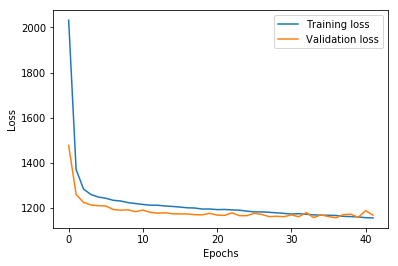

In [91]:
plt.plot(history['loss'], label='Training loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('keras-overfitting.png',dpi=300)
plt.show()



In [29]:

results30 = [x for x in results if abs(x[1] - 0.3)< 0.01]

In [47]:
results30 = [(350, 1162.58)] + results30

In [48]:
#results20 = results20[2:]1159.44
results25 = [(350, 1159.69)]+results25


In [28]:
results

[[400, 0.1, 1099.1994715851074, 1155.3476019734699],
 [400, 0.1, 1143.0598115468106, 1166.0024882197479],
 [400, 0.1, 1113.0639175515391, 1157.9551182049256],
 [400, 0.15000000000000002, 1135.6897099762102, 1163.0742800992123],
 [400, 0.15000000000000002, 1095.3516829969801, 1156.1002882903172],
 [400, 0.15000000000000002, 1135.0787874495943, 1164.116818001325],
 [400, 0.2, 1121.1294441726745, 1161.1796335388224],
 [400, 0.2, 1135.047726785896, 1162.0683303374078],
 [400, 0.2, 1112.807268989295, 1156.7020887315243],
 [400, 0.25, 1110.099020723831, 1156.4297873301414],
 [400, 0.25, 1122.6703099158244, 1159.0686061427102],
 [400, 0.25, 1121.8540941965443, 1159.4466465353498],
 [400, 0.30000000000000004, 1114.2444869256028, 1157.9217288461457],
 [400, 0.30000000000000004, 1108.123549256042, 1153.919180424025],
 [400, 0.30000000000000004, 1106.2679848414157, 1154.4576305063033],
 [450, 0.1, 1126.2725891427262, 1161.342068317449],
 [450, 0.1, 1115.2958719214328, 1157.2834662790226],
 [450, 

In [85]:
results30[4]= (500,1155.66)

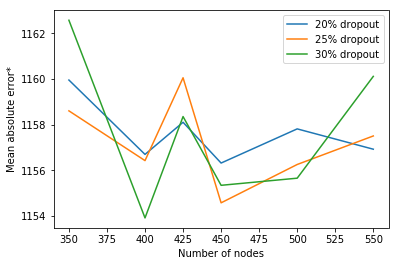

In [92]:
plt.plot([r[0] for r in results20],[r[1] for r in results20],label='20% dropout')
plt.plot([r[0] for r in results25],[r[1] for r in results25],label='25% dropout')
plt.plot([r[0] for r in results30],[r[1] for r in results30],label='30% dropout')
plt.xlabel('Number of nodes')
plt.ylabel('Mean absolute error*')
plt.legend()
plt.savefig('keras-search.png',dpi=300)
plt.show()

In [81]:
results25[4]=(500,1156.26)

In [52]:
results25[0]=(350, 1158.61)